In [1]:
IMAGE_NAME = "spyro.jpg"
TEXT_PROMPT = "toy"

In [2]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))
sys.path.append(os.path.join(os.getcwd(), "SegmentAnything"))

In [3]:

import argparse
import copy

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import load_model, load_image, predict, annotate

import supervision as sv

# segment anything
from SegmentAnything.segment_anything import build_sam, SamPredictor 
import cv2
import numpy as np
import matplotlib.pyplot as plt

/Users/paein/projects/BTP/GroundingDINO/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")
/Users/paein/projects/BTP/GroundingDINO/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [4]:
%ls

1.10.0.tar.gz    SegmentAnything/ cub-1.10.0/
GroundingDINO/   Untitled.ipynb   input/
MCC/             checkpoints/     output/


In [5]:
#Create the COnfig and Pre-Trained Weight path for GroundingDINO
CONFIG_PATH = os.path.join(os.getcwd(), "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(os.getcwd(), "checkpoints", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/Users/paein/projects/BTP/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
/Users/paein/projects/BTP/checkpoints/groundingdino_swint_ogc.pth ; exist: True


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
#loading GroundingDINO
model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/Users/paein/miniconda3/envs/BTP/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
#loading SAM

sam_checkpoint = 'checkpoints/sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)

IMAGE LOADING

In [9]:
# IMAGE_NAME = "dog.png"
IMAGE_PATH = os.path.join(os.getcwd(), "input", IMAGE_NAME)

bgr = cv2.imread(IMAGE_PATH)
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

Classification

In [10]:
#running GroundingDINO

'''
This Piece of codes selects the object from a text prompt, and generates BoundingBox for SAM
'''

# TEXT_PROMPT = "dog"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1] # BGR to RGB

/Users/paein/miniconda3/envs/BTP/lib/python3.9/site-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/Users/paein/miniconda3/envs/BTP/lib/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


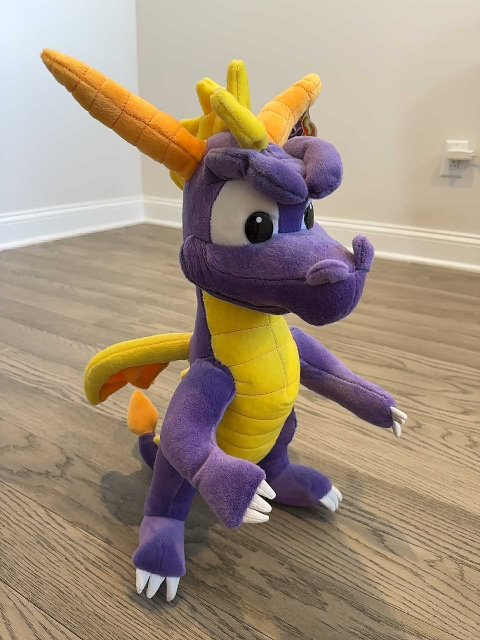

In [11]:
Image.fromarray(image_source)

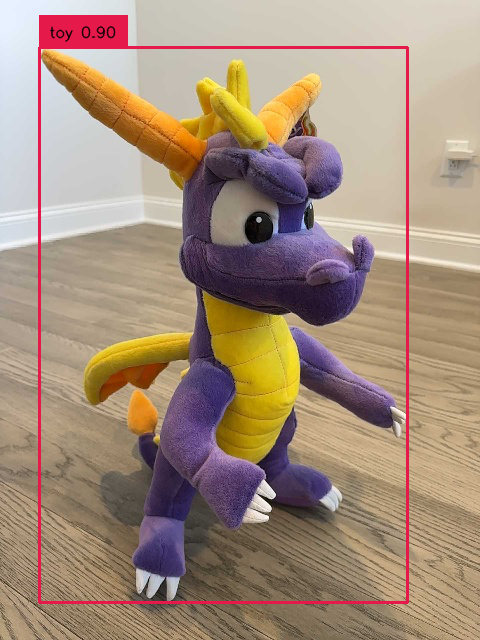

In [12]:
Image.fromarray(annotated_frame)

SEGMENTATION

In [13]:
sam_predictor.set_image(image_source)

In [14]:
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

In [15]:
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(device)
masks, _, _ = sam_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = transformed_boxes,
            multimask_output = False,
        )

In [16]:
#function to display the mask 

def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [17]:
annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)


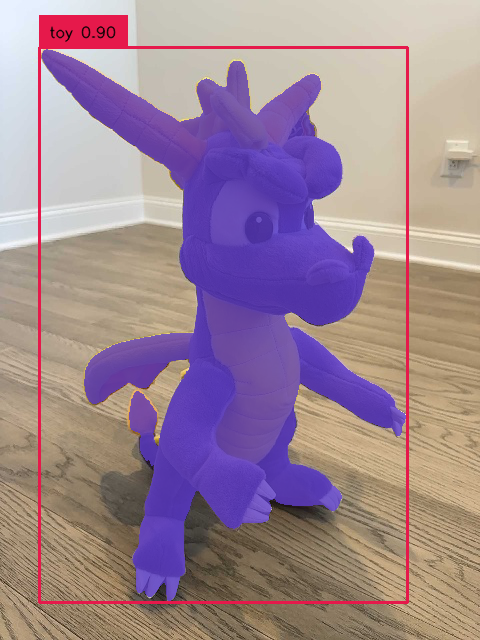

In [18]:
Image.fromarray(annotated_frame_with_mask)


Save Mask

In [19]:
image_mask_pil = Image.fromarray(masks[0][0].cpu().numpy())

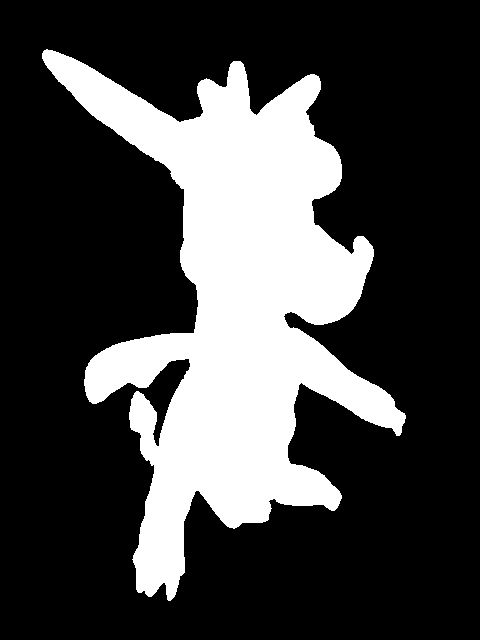

In [20]:
image_mask_pil

In [21]:
output_folder = os.path.join(os.getcwd(), "output/obj_masks")
filename = f"{os.path.splitext(IMAGE_NAME)[0]}_seg.png"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Save the mask as a .png file
image_mask_pil.save(f"{output_folder}/{filename}")

In [22]:
mask_path = os.path.join(output_folder, filename)
print(mask_path)

/Users/paein/projects/BTP/output/obj_masks/spyro_seg.png


DEPTH

In [23]:
# seen in this context means the points that are visible in the image
s_rgb = (torch.tensor(bgr).float() / 255)[..., [2, 1, 0]]
H, W = s_rgb.shape[:2]
s_rgb = torch.nn.functional.interpolate(
    s_rgb.permute(2, 0, 1)[None],
    size=[H, W],
    mode="bilinear",
    align_corners=False,
)[0].permute(1, 2, 0)

In [24]:
# torch.hub.help("intel-isl/MiDaS", "DPT_BEiT_L_384", force_reload=True)  # Triggers fresh download of MiDaS repo

In [25]:
#load ZoeDepth and generate depth map

depth_model = torch.hub.load('isl-org/ZoeDepth', "ZoeD_N", pretrained=True).to("cpu").eval()
depth = depth_model.infer(s_rgb.permute(2, 0, 1)[None].cpu())
depth = depth[0].permute(1, 2, 0)
depth = depth.cpu().detach().numpy().squeeze()

Using cache found in /Users/paein/.cache/torch/hub/isl-org_ZoeDepth_main


img_size [384, 512]


Using cache found in /Users/paein/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


PROJECT DEPTH MAP TO POINT CLOUD

In [26]:
def get_intrinsics(H,W):
    """
    Intrinsics for a pinhole camera model.
    Assume fov of 55 degrees and central principal point.
    """
    f = 0.5 * W / np.tan(0.5 * 55 * np.pi / 180.0)
    cx = 0.5 * W
    cy = 0.5 * H
    return np.array([[f, 0, cx],
                     [0, f, cy],
                     [0, 0, 1]])


def backproject_depth_to_pointcloud(depth, rotation=np.eye(3), translation=np.zeros(3)):
    intrinsics = get_intrinsics(depth.shape[0], depth.shape[1])
    # Get the depth map shape
    height, width = depth.shape

    # Create a matrix of pixel coordinates
    u, v = np.meshgrid(np.arange(width), np.arange(height))
    uv_homogeneous = np.stack((u, v, np.ones_like(u)), axis=-1).reshape(-1, 3)

    # Invert the intrinsic matrix
    inv_intrinsics = np.linalg.inv(intrinsics)

    # Convert depth to the camera coordinate system
    points_cam_homogeneous = np.dot(uv_homogeneous, inv_intrinsics.T) * depth.flatten()[:, np.newaxis]

    # Convert to 3D homogeneous coordinates
    points_cam_homogeneous = np.concatenate((points_cam_homogeneous, np.ones((len(points_cam_homogeneous), 1))), axis=1)

    # Apply the rotation and translation to get the 3D point cloud in the world coordinate system
    extrinsics = np.hstack((rotation, translation[:, np.newaxis]))
    pointcloud = np.dot(points_cam_homogeneous, extrinsics.T)

    # Reshape the point cloud back to the original depth map shape
    pointcloud = pointcloud[:, :3].reshape(height, width, 3)

    return pointcloud


def save_point_cloud_to_obj(point_cloud, output_file):
    with open(output_file, 'w') as f:
        for y in range(point_cloud.shape[0]):
            for x in range(point_cloud.shape[1]):
                point = point_cloud[y, x]
                f.write(f'v {point[0]} {point[1]} {point[2]}\n')
                
                
def read_depth_map_from_png(png_file):
    depth_map = cv2.imread(png_file, cv2.IMREAD_UNCHANGED)
    depth_map = depth_map.astype(np.float32)
    return depth_map

In [27]:
point_cloud = backproject_depth_to_pointcloud(depth)

op_folder = os.path.join(os.getcwd(), "output/pcd_objects")
op_filename = f"{os.path.splitext(IMAGE_NAME)[0]}.obj"

if not os.path.exists(op_folder):
    os.makedirs(op_folder)
    
output_file = f"{op_folder}/{op_filename}"

save_point_cloud_to_obj(point_cloud, output_file)

In [28]:
def point_cloud_to_depth_map(point_cloud, img_shape):
    """
    Project a point cloud into a depth map.
    point_cloud: numpy array of shape (N, 3) with 3D coordinates in the camera frame
    K: intrinsic camera matrix
    img_shape: tuple with the shape of the depth map (height, width)
    """
    K = get_intrinsics(img_shape[0], img_shape[1])
    # Project 3D points to 2D image coordinates
    points_2d = K @ point_cloud.T
    points_2d /= points_2d[2, :]
    points_2d = points_2d[:2, :].T

    # Round the 2D points to integers
    points_2d = np.round(points_2d).astype(int)

    # Filter out points outside the image dimensions
    valid_points = (0 <= points_2d[:, 0]) & (points_2d[:, 0] < img_shape[1]) & \
          (0 <= points_2d[:, 1]) & (points_2d[:, 1] < img_shape[0])
    points_2d = points_2d[valid_points]
    point_cloud = point_cloud[valid_points]

    # Create a depth map and fill in the depths at the corresponding 2D points
    depth_map = np.zeros(img_shape, dtype=np.float32)
    depth_map[points_2d[:, 1], points_2d[:, 0]] = point_cloud[:, 2]

    return depth_map

In [30]:
from pytorch3d.io.obj_io import load_obj
obj = load_obj(output_file)
# Verts from OBJ file reshaped to image size
s_xyz = obj[0].reshape(H, W, 3)
depth_col = point_cloud_to_depth_map(obj[0].numpy(), (H, W))

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/Users/paein/miniconda3/envs/BTP/lib/python3.9/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/Users/paein/miniconda3/envs/BTP/lib/python3.9/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt
/Users/paein/miniconda3/envs/BTP/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


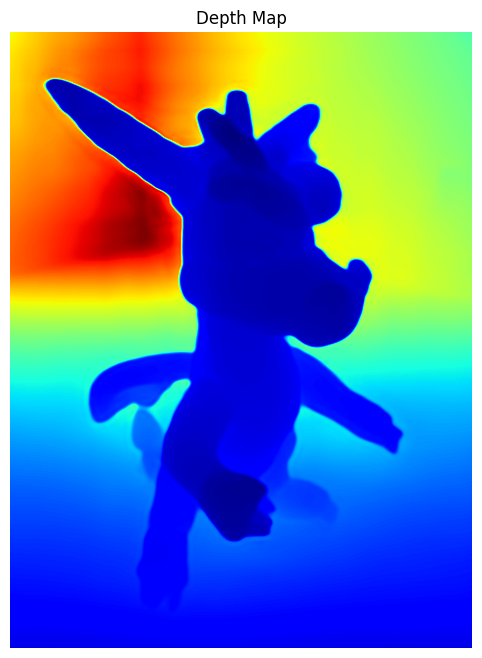

In [31]:
import matplotlib.pyplot as plt

def visualize_depth_map(depth_map):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))

    # Display the depth map as an image
    ax.imshow(depth_map, cmap='jet')
    ax.set_title('Depth Map')
    ax.axis('off')

    # Show the plot
    plt.show()

visualize_depth_map(depth_col)


In [32]:
print(IMAGE_PATH)
print(mask_path)
print(output_file)

/Users/paein/projects/BTP/input/spyro.jpg
/Users/paein/projects/BTP/output/obj_masks/spyro_seg.png
/Users/paein/projects/BTP/output/pcd_objects/spyro.obj


3D RECONSTRUCTION

In [33]:
sys.path.append(os.path.join(os.getcwd(), "MCC"))

In [34]:
import numpy as np
import cv2
from tqdm import tqdm

import torch
from pytorch3d.io.obj_io import load_obj

import MCC.main_mcc as main_mcc
import MCC.mcc_model as mcc_model
import MCC.util.misc as misc
from MCC.engine_mcc import prepare_data, generate_html

In [35]:
def run_viz(model, samples, device, args, prefix):
    model.eval()

    seen_xyz, valid_seen_xyz, unseen_xyz, unseen_rgb, labels, seen_images = prepare_data(
        samples, device, is_train=False, args=args, is_viz=True
    )
    pred_occupy = []
    pred_colors = []

    max_n_unseen_fwd = 2000

    model.cached_enc_feat = None
    num_passes = int(np.ceil(unseen_xyz.shape[1] / max_n_unseen_fwd))
    for p_idx in tqdm(range(num_passes)):
        p_start = p_idx     * max_n_unseen_fwd
        p_end = (p_idx + 1) * max_n_unseen_fwd
        cur_unseen_xyz = unseen_xyz[:, p_start:p_end]
        cur_unseen_rgb = unseen_rgb[:, p_start:p_end].zero_()
        cur_labels = labels[:, p_start:p_end].zero_()

        with torch.no_grad():
            _, pred = model(
                seen_images=seen_images,
                seen_xyz=seen_xyz,
                unseen_xyz=cur_unseen_xyz,
                unseen_rgb=cur_unseen_rgb,
                unseen_occupy=cur_labels,
                cache_enc=True,
                valid_seen_xyz=valid_seen_xyz,
            )
        pred_occupy.append(pred[..., 0].cpu())
        if args.regress_color:
            pred_colors.append(pred[..., 1:].reshape((-1, 3)))
        else:
            pred_colors.append(
                (
                    torch.nn.Softmax(dim=2)(
                        pred[..., 1:].reshape((-1, 3, 256)) / args.temperature
                    ) * torch.linspace(0, 1, 256, device=pred.device)
                ).sum(axis=2)
            )
    with open(prefix + f"_{os.path.splitext(IMAGE_NAME)[0]}" +'.html', 'a') as f:
        generate_html(
            None,
            None, None,
            torch.cat(pred_occupy, dim=1),
            torch.cat(pred_colors, dim=0),
            unseen_xyz,
            f,
            gt_xyz=None,
            gt_rgb=None,
            mesh_xyz=None,
            score_thresholds=args.score_thresholds,
            pointcloud_marker_size=3,
        )

def pad_image(im, value):
    if im.shape[0] > im.shape[1]:
        diff = im.shape[0] - im.shape[1]
        return torch.cat([im, (torch.zeros((im.shape[0], diff, im.shape[2])) + value)], dim=1)
    else:
        diff = im.shape[1] - im.shape[0]
        return torch.cat([im, (torch.zeros((diff, im.shape[1], im.shape[2])) + value)], dim=0)


def normalize(seen_xyz):
    seen_xyz = seen_xyz / (seen_xyz[torch.isfinite(seen_xyz.sum(dim=-1))].var(dim=0) ** 0.5).mean()
    seen_xyz = seen_xyz - seen_xyz[torch.isfinite(seen_xyz.sum(dim=-1))].mean(axis=0)
    return seen_xyz


def main(args):

    model = mcc_model.get_mcc_model(
        occupancy_weight=1.0,
        rgb_weight=0.01,
        args=args,
    ).cpu()

    misc.load_model(args=args, model_without_ddp=model, optimizer=None, loss_scaler=None)

#     rgb = cv2.imread(args.image)
    obj = load_obj(args.point_cloud)

    seen_rgb = (torch.tensor(bgr).float() / 255)[..., [2, 1, 0]]
    H, W = seen_rgb.shape[:2]
    seen_rgb = torch.nn.functional.interpolate(
        seen_rgb.permute(2, 0, 1)[None],
        size=[H, W],
        mode="bilinear",
        align_corners=False,
    )[0].permute(1, 2, 0)

    seen_xyz = obj[0].reshape(H, W, 3)
    seg = cv2.imread(args.seg, cv2.IMREAD_UNCHANGED)
    mask = torch.tensor(cv2.resize(seg, (W, H))).bool()
    seen_xyz[~mask] = float('inf')

    seen_xyz = normalize(seen_xyz)

    bottom, right = mask.nonzero().max(dim=0)[0]
    top, left = mask.nonzero().min(dim=0)[0]

    bottom = bottom + 40
    right = right + 40
    top = max(top - 40, 0)
    left = max(left - 40, 0)

    seen_xyz = seen_xyz[top:bottom+1, left:right+1]
    seen_rgb = seen_rgb[top:bottom+1, left:right+1]

    seen_xyz = pad_image(seen_xyz, float('inf'))
    seen_rgb = pad_image(seen_rgb, 0)

    seen_rgb = torch.nn.functional.interpolate(
        seen_rgb.permute(2, 0, 1)[None],
        size=[800, 800],
        mode="bilinear",
        align_corners=False,
    )

    seen_xyz = torch.nn.functional.interpolate(
        seen_xyz.permute(2, 0, 1)[None],
        size=[112, 112],
        mode="bilinear",
        align_corners=False,
    ).permute(0, 2, 3, 1)

    samples = [
        [seen_xyz, seen_rgb],
        [torch.zeros((20000, 3)), torch.zeros((20000, 3))],
    ]
    run_viz(model, samples, "cpu", args, prefix=args.output)


In [36]:
print(IMAGE_PATH)
print(mask_path)
print(output_file)

/Users/paein/projects/BTP/input/spyro.jpg
/Users/paein/projects/BTP/output/obj_masks/spyro_seg.png
/Users/paein/projects/BTP/output/pcd_objects/spyro.obj


In [37]:
parser = main_mcc.get_args_parser()
parser.add_argument('--image', default=IMAGE_PATH, type=str, help='input image file')
parser.add_argument('--point_cloud', default=output_file, type=str, help='input obj file')
parser.add_argument('--seg', default=mask_path, type=str, help='input obj file')
parser.add_argument('--output', default='output/3D', type=str, help='output path')
parser.add_argument('--granularity', default=0.05, type=float, help='output granularity')
parser.add_argument('--score_thresholds', default=[0.1, 0.2, 0.3, 0.4, 0.5], type=float, nargs='+', help='score thresholds')
parser.add_argument('--temperature', default=0.1, type=float, help='temperature for color prediction.')
parser.add_argument('--checkpoint', default='MCC/co3dv2_all_categories.pth', type=str, help='model checkpoint')

parser.set_defaults(eval=True)

args = parser.parse_args(args=[])
args.resume = args.checkpoint
args.viz_granularity = args.granularity

In [38]:
main(args)

Resume checkpoint MCC/co3dv2_all_categories.pth


An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/Users/paein/miniconda3/envs/BTP/lib/python3.9/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/Users/paein/miniconda3/envs/BTP/lib/python3.9/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt


_IncompatibleKeys(missing_keys=[], unexpected_keys=['mask_token'])


/Users/paein/miniconda3/envs/BTP/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")
  0%|                                                   | 0/864 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|█████████████████████████████████████████| 864/864 [26:49<00:00,  1.86s/it]


In [39]:
final = f"output/3D_{os.path.splitext(IMAGE_NAME)[0]}.html"
print(final)

output/3D_spyro.html


In [41]:
from IPython.display import IFrame

# Specify the path to the saved HTML file
html_file = final

# Display the HTML file using IFrame
IFrame(src=html_file, width='100%', height='800px')
